<a href="https://colab.research.google.com/github/adindaayundra/PlantDiseaseClassification_Versi2/blob/main/PlantDiseaseClassification_MbkmRiset_Versi2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# **Implementation Plant Disease Classification Use Deep Learning** 
### by : Kurnia Adinda Ayundra Putri - 18.11.0173
---

>Goals : Projek ini dapat membangun sebuah model yang dapat mengklasifikasikan antara daun tanaman yang sehat dan yang tidak sehat dan juga jika tanaman tersebut memiliki penyakit, kita dapat memprediksi jenis penyakitnya.


#Library and Data Preparation

* Importing necessary libraries :  



In [ ]:
!pip install kaggle
from google.colab import files

upload = files.upload()
for k in upload.keys():
  print(k)

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from PIL import Image
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchsummary import summary

%matplotlib inline

*  Exploring the data :



In [ ]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

new-plant-diseases-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -q /content/new-plant-diseases-dataset.zip

replace New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace New Plant Diseases Dataset(Augmented)/New Pl

In [ ]:
data_dir = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
diseases = os.listdir(train_dir)

In [ ]:
print(diseases)

['Cherry_(including_sour)___Powdery_mildew', 'Raspberry___healthy', 'Potato___healthy', 'Tomato___Early_blight', 'Tomato___Bacterial_spot', 'Blueberry___healthy', 'Soybean___healthy', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___healthy', 'Tomato___Septoria_leaf_spot', 'Tomato___Late_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Orange___Haunglongbing_(Citrus_greening)', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Corn_(maize)___Common_rust_', 'Apple___healthy', 'Strawberry___healthy', 'Pepper,_bell___Bacterial_spot', 'Corn_(maize)___healthy', 'Tomato___Leaf_Mold', 'Grape___Esca_(Black_Measles)', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Tomato_mosaic_virus', 'Apple___Cedar_apple_rust', 'Grape___Black_rot', 'Peach___Bacterial_spot', 'Potato___Early_blight', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Peach___healthy', 'Grape___healthy', 'Apple___Black_rot', 'Potato___Late_blight', 'Strawberry___Leaf_scorc

In [ ]:
print("Total disease classes are: {}".format(len(diseases)))

Total disease classes are: 38


In [ ]:
plants = []
num_diseases = 0

for plant in diseases:
  if plant.split('___')[0] not in plants:
    plants.append(plant.split('___')[0])
  if plant.split('___')[1] != 'healthy':
    num_diseases +=1

In [ ]:
print(f"Unique Plants are: \n{plants}")

Unique Plants are: 
['Cherry_(including_sour)', 'Raspberry', 'Potato', 'Tomato', 'Blueberry', 'Soybean', 'Corn_(maize)', 'Orange', 'Apple', 'Strawberry', 'Pepper,_bell', 'Grape', 'Peach', 'Squash']


In [ ]:
print("Number of plants: {}".format(len(plants)))

Number of plants: 14


In [ ]:
print("Number of diseases: {}".format(num_diseases))

Number of diseases: 26


In [ ]:
nums = {}
for position in diseases:
    nums[position] = len(os.listdir(train_dir + '/' + position))   

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=['Total Images']) 
img_per_class

,Total Images
Cherry_(including_sour)___Powdery_mildew,1683
Raspberry___healthy,1781
Potato___healthy,1824
Tomato___Early_blight,1920
Tomato___Bacterial_spot,1702
Blueberry___healthy,1816
Soybean___healthy,2022
Tomato___Tomato_Yellow_Leaf_Curl_Virus,1961
Tomato___healthy,1926
Tomato___Septoria_leaf_spot,1745


* Visualizing the above information on a graph :


Text(0.5, 1.0, 'Images per each class of plant disease')

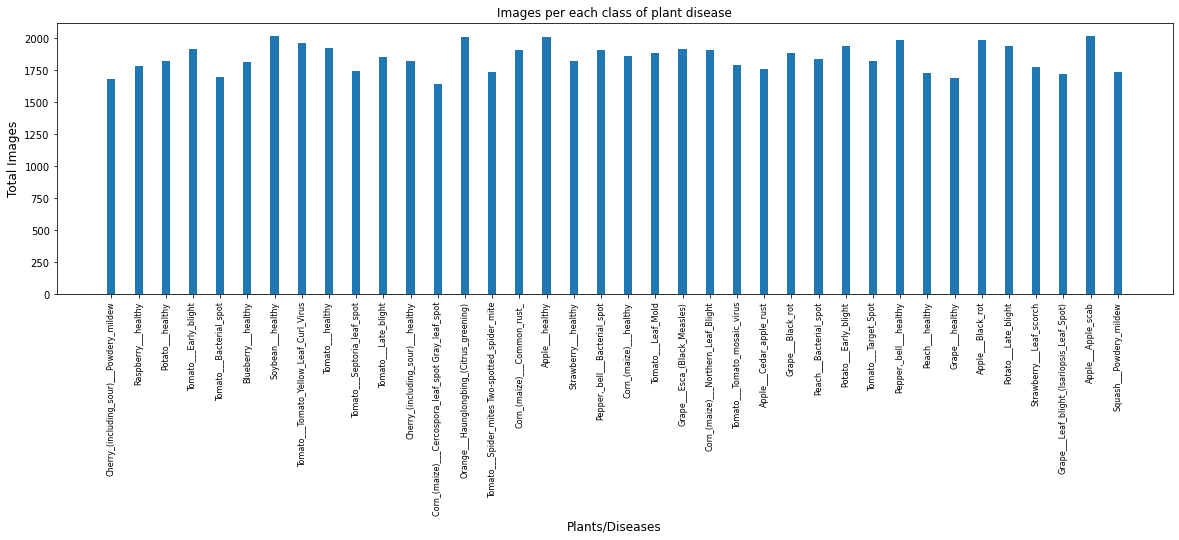

In [ ]:
index = [a for a in range(38)]
plt.figure(figsize=(20, 5))
plt.bar(index, [a for a in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=12)
plt.ylabel('Total Images', fontsize=12)
plt.xticks(index, diseases, fontsize=8, rotation=90)
plt.title('Images per each class of plant disease')



*   Images available for training :


In [ ]:
a_train = 0
for value in nums.values():
  a_train += value
print(f"There are {a_train} images for training")

There are 70295 images for training


# Data Preparation for Training

In [ ]:
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor())

* Image Shape :

In [ ]:
img, label = train [0]
print(img.shape, label)

torch.Size([3, 256, 256]) 0


In [ ]:
len(train.classes)

38

In [ ]:
def show_image(image, label):
  print("Label :" + train.classes[label] + "(" + str(label) + ")")

  plt.imshow(image.permute(1, 2, 0))

# Some Images from training dataset

Label :Apple___Apple_scab(0)


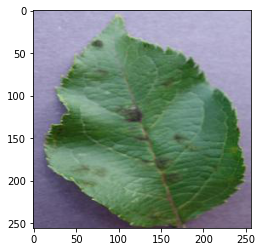

In [ ]:
show_image(*train[0])

Label :Tomato___healthy(37)


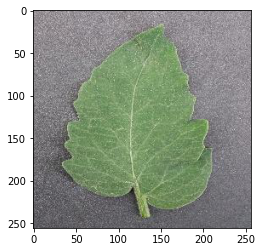

In [ ]:
show_image(*train[70000])

Label :Blueberry___healthy(4)


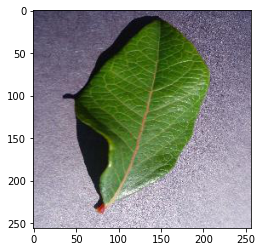

In [ ]:
show_image(*train[9000])

Label :Corn_(maize)___Common_rust_(8)


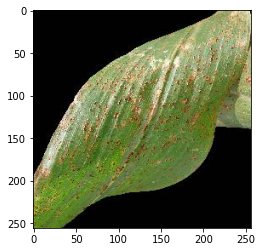

In [ ]:
show_image(*train[15000])

In [ ]:
random_seed = 8
torch.manual_seed(random_seed)

In [ ]:
batch_size = 32

In [ ]:
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)

valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

In [ ]:
def show_batch(data):
  for images, labels in data:
    fig, ax = plt.subplots(figsize=(30, 30))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
    break

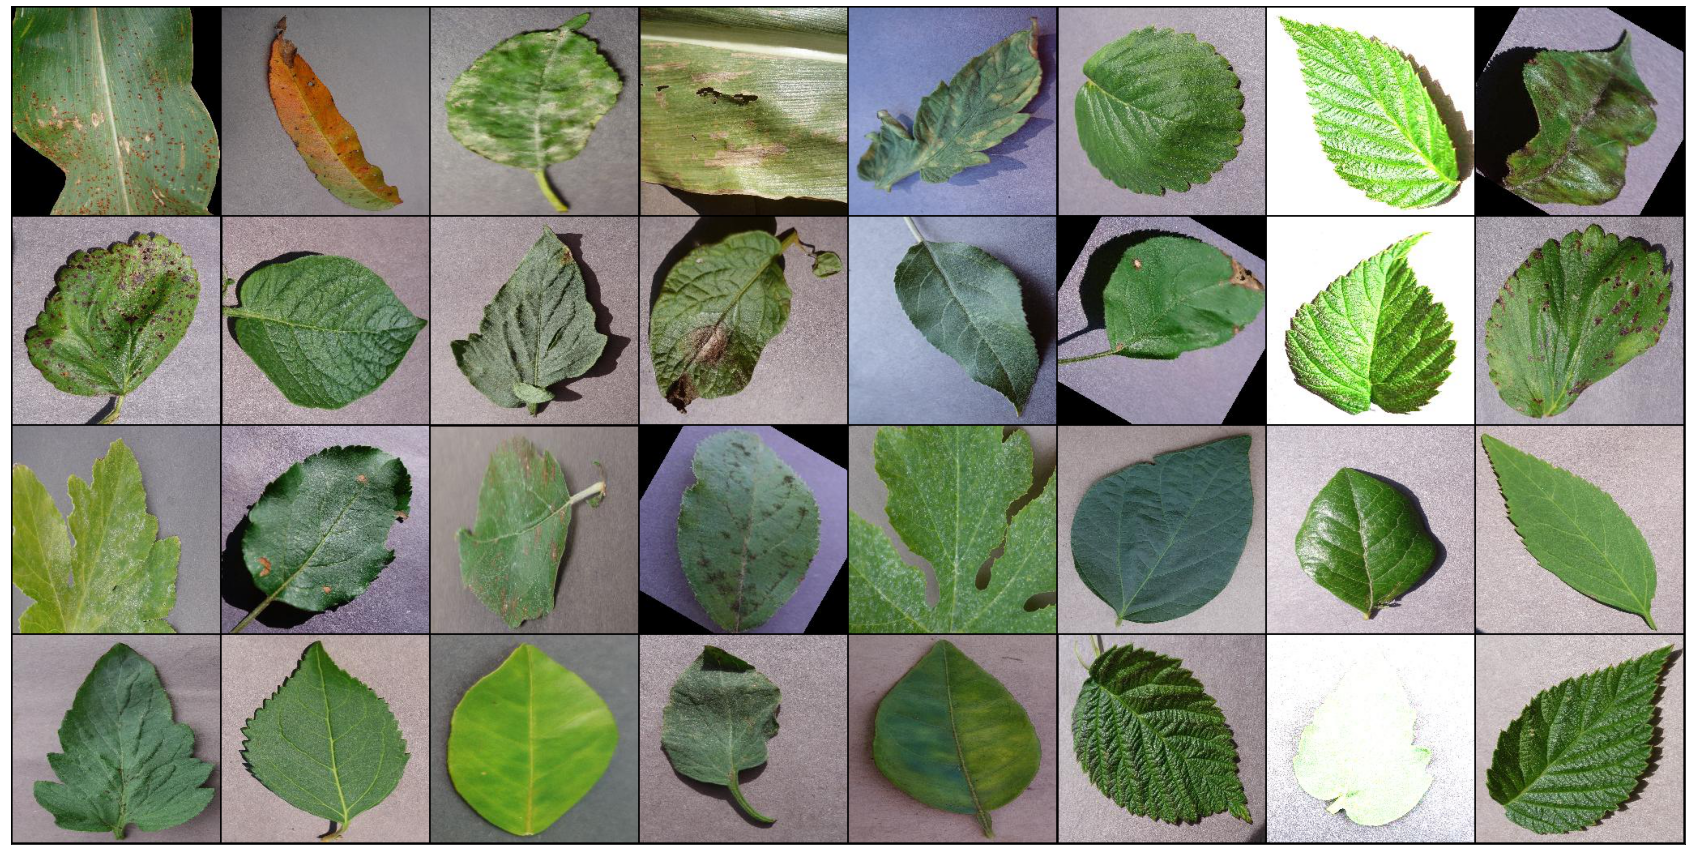

In [ ]:
show_batch(train_dl)

# Modelling

* Some helper functions   

In [ ]:
def get_default_device():
  if torch.cuda.is_available:
    return torch.device("cuda")
  else:
    return torch.device("cpu")

def to_device(data, device):
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)


*   Checking the device we are working with :

In [ ]:
device = get_default_device()
device

device(type='cuda')

*   Moving data into GPU

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

# Building the Model Architecture

*   Residual Block Code Implementation :

In [ ]:
class SimpleResidualBlock(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
    self.relu2 = nn.ReLU()

  def forward(self, x):
    out = self.conv1(x)
    out = self.relu1(out)
    out = self.conv2(out)
    return self.relu2(out) + x

In [ ]:
# code buat kalkulasi akurasi: 
# subhanallah susah bet :'v

def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# base class for the model
class ImageClassificationBase(nn.Module):

  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {"val_loss": loss.detach(), "val_accuracy": acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x["val_loss"] for x in outputs]
    batch_accuracy = [x["val_accuracy"] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    epoch_accuracy = torch.stack(batch_accuracy).mean()
    return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

# Defining the Final Architecture of our Model

In [ ]:
# Architecture for training

def ConvBlock(in_channels, out_channels, pool=False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)]
    if pool:
      layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)

# ResNet acrhitecture
class ResNet9(ImageClassificationBase):
  def __init__(self, in_channels, num_diseases):
    super().__init__()

    self.conv1 = ConvBlock(in_channels, 64)
    self.conv2 = ConvBlock(64, 128, pool=True)
    self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
    self.conv3 = ConvBlock(128, 256, pool=True)
    self.conv4 = ConvBlock(256, 512, pool=True)
    self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))

    self.classifier = nn.Sequential(nn.MaxPool2d)(4),
                                    nn.Flatten(),
                                    nn.Linear(512, num_diseases)
  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.classifier(out)
    return out